In [2]:
import os
import wandb
from dotenv import load_dotenv

In [3]:
import tensorflow as tf

# Enable memory growth
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"✅ Enabled memory growth for {len(gpus)} GPU(s)")
    except RuntimeError as e:
        print(e)

# Prevent Out Of Memory
os.environ['TF_GPU_ALLOCATOR'] = 'cuda_malloc_async'

✅ Enabled memory growth for 1 GPU(s)


2026-02-18 16:19:02.232115: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-18 16:19:02.238513: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-18 16:19:02.240458: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [4]:
# load variables from env
load_dotenv()

# Start weights and biases
wandb.login()


wandb: [wandb.login()] Loaded credentials for https://api.wandb.ai from WANDB_API_KEY.
wandb: Currently logged in as: coffeedrunk to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [5]:
# Read the dataset
from utils.data import load_data

X_train, y_train, X_test, y_test, labels = load_data()

n_labels = len(labels)

In [6]:
# Preprocessing

from keras.utils import to_categorical
from keras.layers import Rescaling
import tensorflow as tf

# Convert labels to one-hot vectors
y_train_cat = to_categorical(y_train, num_classes=n_labels)
y_test_cat = to_categorical(y_test, num_classes=n_labels)

# https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/
# Create a preprocessing layer for normalization
normalization_layer = Rescaling(1./255)
X_train = normalization_layer(X_train)
X_test = normalization_layer(X_test)


2026-02-18 16:19:07.157456: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-18 16:19:07.159525: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2026-02-18 16:19:07.161252: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [7]:
X_train.shape, X_test.shape

(TensorShape([50000, 32, 32, 3]), TensorShape([10000, 32, 32, 3]))

In [8]:
y_train_cat.shape, y_test_cat.shape

((50000, 10), (10000, 10))

In [ ]:
import tensorflow as tf
from wandb.integration.keras import WandbMetricsLogger

# STEP 1: Configure Experiment
config = {
    "dataset": "CIFAR-10",
    "architecture": "SimpleCNN",
    "batch_size": 64,
    "epochs": 20,
    "learning_rate": 0.001,
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    "validation_split": 0.2,
}

In [9]:
# STEP 2: Initialize W&B Project Run 
project_name="deep-learning-cifar10-classification"

run = wandb.init(
    project=project_name,
    config=config,
    name="baseline_cnn_v1",  # Change this for each experiment!
    tags=["baseline", "cnn", "scratch"],  # Organize experiments
    notes="Simple 3-layer CNN with batch normalization"
)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [11]:
# ========== STEP 3: Build & Compile Model ==========
import tensorflow as tf
from utils.models import baseline_cnn, simple_cnn, deeper_cnn

model = baseline_cnn()
optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])

model.compile(
    optimizer=optimizer,
    loss=config["loss"],
    metrics=['accuracy']
)

# ========== STEP 4: Train with W&B Callbacks ==========
history = model.fit(
    X_train, y_train_cat,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    validation_split=0.2,
    callbacks=[
        WandbMetricsLogger(),  # Auto-logs all metrics
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

# ========== STEP 5: Evaluate & Log Results ==========
val_loss, val_accuracy = model.evaluate(X_test, y_test_cat)
wandb.log({
    "final_val_loss": val_loss,
    "final_val_accuracy": val_accuracy
})



Epoch 1/20


2026-02-18 15:46:15.462376: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2026-02-18 15:47:01.516801: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2026-02-18 15:47:01.516821: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2026-02-18 15:47:01.516864: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2026-02-18 15:47:01.612711: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2026-02-18 15:47:01.612871: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by dr

625/625 [==============================] - 107s 14ms/step - loss: 1.6914 - accuracy: 0.4042 - val_loss: 1.4995 - val_accuracy: 0.4363
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 1.3357 - accuracy: 0.5246 - val_loss: 1.2358 - val_accuracy: 0.5744
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 1.1685 - accuracy: 0.5886 - val_loss: 1.0811 - val_accuracy: 0.6212
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 1.0590 - accuracy: 0.6302 - val_loss: 1.0275 - val_accuracy: 0.6386
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.9790 - accuracy: 0.6554 - val_loss: 1.1084 - val_accuracy: 0.6355
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.9036 - accuracy: 0.6836 - val_loss: 0.9695 - val_accuracy: 0.6697
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.8393 - accuracy: 0.7035 - val_loss: 0.9613 - val_accuracy: 0.6651
Epoch 8/20
625

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=64)

157/157 [==============================] - 0s 960us/step - loss: 0.9111 - accuracy: 0.7033


In [14]:
import numpy as np
from utils.metrics import get_metrics_report, plot_confusion_matrix

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

report = get_metrics_report(y_test, y_pred, labels)


313/313 [==============================] - 0s 639us/step
              precision    recall  f1-score   support

    airplane       0.68      0.77      0.72      1000
  automobile       0.83      0.81      0.82      1000
        bird       0.53      0.67      0.59      1000
         cat       0.53      0.52      0.53      1000
        deer       0.67      0.67      0.67      1000
         dog       0.71      0.49      0.58      1000
        frog       0.75      0.82      0.79      1000
       horse       0.79      0.74      0.76      1000
        ship       0.76      0.86      0.81      1000
       truck       0.86      0.68      0.76      1000

    accuracy                           0.70     10000
   macro avg       0.71      0.70      0.70     10000
weighted avg       0.71      0.70      0.70     10000



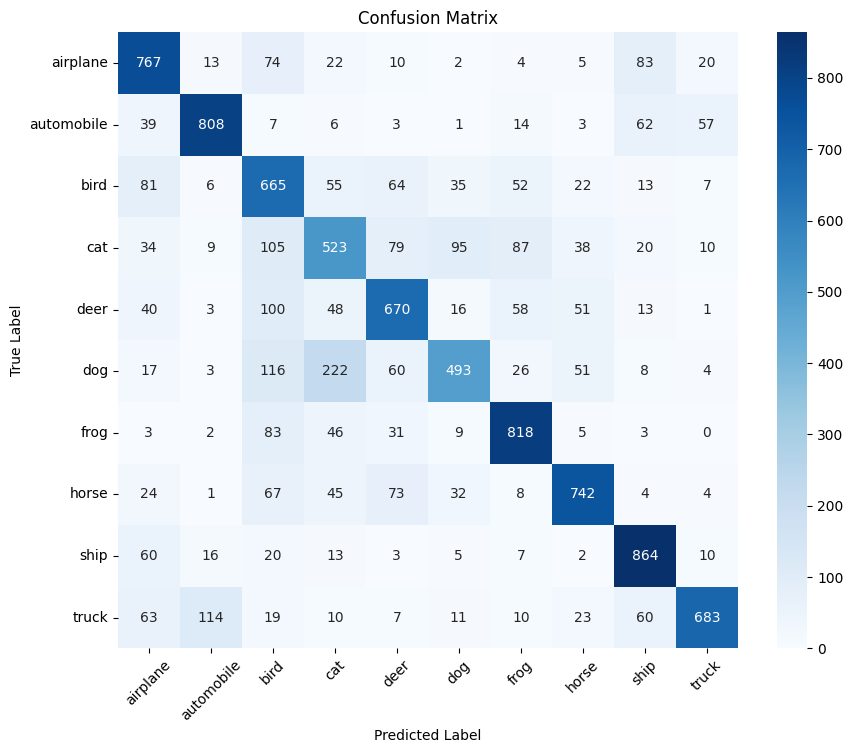

In [15]:
plot_confusion_matrix(y_test, y_pred, labels)

In [17]:
# ========== STEP 6: Save Model & Finish ==========
models_dir = "models/"

if not os.path.isdir(models_dir):
    os.mkdir(models_dir)


model.save("models/best_model.keras")
wandb.log_artifact("models/best_model.keras", type="model")
wandb.finish()

epoch/accuracy,▁▃▄▅▅▆▆▆▆▇▇▇▇█████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁
epoch/val_accuracy,▁▅▆▆▆▇▇▇▇▇▇██▇▇███
epoch/val_loss,█▅▃▂▃▂▂▂▁▂▂▂▁▃▂▂▂▂
final_val_accuracy,▁
final_val_loss,▁
epoch/accuracy,0.82758
epoch/epoch,17
epoch/learning_rate,0.001


## Model 2

In [16]:
import tensorflow as tf
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

# STEP 1: Configure Experiment
config = {
    "dataset": "CIFAR-10",
    "architecture": "SimpleCNN",
    "batch_size": 64,
    "epochs": 20,
    "learning_rate": 0.001,
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    "validation_split": 0.2,
}

In [18]:
# STEP 2: Initialize W&B Project Run 
project_name="deep-learning-cifar10-classification"

run = wandb.init(
    project=project_name,
    config=config,
    name="simple_cnn_v1",  # Change this for each experiment!
    tags=["baseline", "cnn", "scratch"],  # Organize experiments
    notes="Simple 3-layer CNN no batch normalization"
)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [19]:
# ========== STEP 3: Build & Compile Model ==========
import tensorflow as tf
from utils.models import baseline_cnn, simple_cnn, deeper_cnn

model = simple_cnn()
optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])

model.compile(
    optimizer=optimizer,
    loss=config["loss"],
    metrics=['accuracy']
)

# ========== STEP 4: Train with W&B Callbacks ==========
history = model.fit(
    X_train, y_train_cat,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    validation_split=0.2,
    callbacks=[
        WandbMetricsLogger(),  # Auto-logs all metrics
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

# ========== STEP 5: Evaluate & Log Results ==========
val_loss, val_accuracy = model.evaluate(X_test, y_test_cat)
wandb.log({
    "final_val_loss": val_loss,
    "final_val_accuracy": val_accuracy
})



Epoch 1/20
625/625 [==============================] - 2s 2ms/step - loss: 1.5347 - accuracy: 0.4495 - val_loss: 1.2405 - val_accuracy: 0.5677
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 1.1593 - accuracy: 0.5943 - val_loss: 1.1252 - val_accuracy: 0.6062
Epoch 3/20
625/625 [==============================] - 1s 1ms/step - loss: 1.0305 - accuracy: 0.6417 - val_loss: 1.0505 - val_accuracy: 0.6342
Epoch 4/20
625/625 [==============================] - 1s 1ms/step - loss: 0.9316 - accuracy: 0.6780 - val_loss: 0.9800 - val_accuracy: 0.6647
Epoch 5/20
625/625 [==============================] - 1s 1ms/step - loss: 0.8629 - accuracy: 0.7004 - val_loss: 0.9573 - val_accuracy: 0.6780
Epoch 6/20
625/625 [==============================] - 1s 1ms/step - loss: 0.8030 - accuracy: 0.7225 - val_loss: 0.9239 - val_accuracy: 0.6866
Epoch 7/20
625/625 [==============================] - 1s 1ms/step - loss: 0.7466 - accuracy: 0.7424 - val_loss: 1.0110 - val_accuracy: 0.6550
Epoch 

In [20]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=64)

157/157 [==============================] - 0s 1ms/step - loss: 0.9173 - accuracy: 0.6945


In [21]:
import numpy as np
from utils.metrics import get_metrics_report, plot_confusion_matrix

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

report = get_metrics_report(y_test, y_pred, labels)


313/313 [==============================] - 0s 738us/step
              precision    recall  f1-score   support

    airplane       0.69      0.82      0.75      1000
  automobile       0.80      0.83      0.81      1000
        bird       0.57      0.60      0.59      1000
         cat       0.49      0.54      0.51      1000
        deer       0.65      0.60      0.62      1000
         dog       0.65      0.54      0.59      1000
        frog       0.79      0.74      0.77      1000
       horse       0.75      0.74      0.74      1000
        ship       0.79      0.80      0.80      1000
       truck       0.80      0.73      0.77      1000

    accuracy                           0.69     10000
   macro avg       0.70      0.69      0.69     10000
weighted avg       0.70      0.69      0.69     10000



In [22]:
# ========== STEP 6: Save Model & Finish ==========
models_dir = "models/"

if not os.path.isdir(models_dir):
    os.mkdir(models_dir)


model.save("models/best_model.keras")
wandb.log_artifact("models/best_model.keras", type="model")
wandb.finish()

epoch/accuracy,▁▄▅▅▆▆▆▇▇▇▇██
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▆▅▄▄▃▃▂▂▂▂▁▁
epoch/val_accuracy,▁▃▄▆▇▇▆████▇█
epoch/val_loss,█▆▄▂▂▁▃▁▁▁▂▂▂
final_val_accuracy,▁
final_val_loss,▁
epoch/accuracy,0.83365
epoch/epoch,12
epoch/learning_rate,0.001


## Model 3

In [9]:
import tensorflow as tf
from wandb.integration.keras import WandbMetricsLogger

# STEP 1: Configure Experiment
config = {
    "dataset": "CIFAR-10",
    "architecture": "DeeperCNN",
    "batch_size": 64,
    "epochs": 20,
    "learning_rate": 0.001,
    "optimizer": "adam",
    "loss": "categorical_crossentropy",
    "validation_split": 0.2,
}
# STEP 2: Initialize W&B Project Run 
project_name="deep-learning-cifar10-classification"

run = wandb.init(
    project=project_name,
    config=config,
    name="deeper_cnn_v1",  # Change this for each experiment!
    tags=["baseline", "cnn", "scratch"],  # Organize experiments
    notes="Simple CNN with batch normalization"
)

/usr/local/lib/python3.10/dist-packages/pydantic/main.py:308: UserWarning: Pydantic serializer warnings:
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  Expected `list[str]` but got `tuple` - serialized value may not be as expected
  return self.__pydantic_serializer__.to_python(


In [11]:
# ========== STEP 3: Build & Compile Model ==========
import tensorflow as tf
from utils.models import baseline_cnn, simple_cnn, deeper_cnn

model = deeper_cnn()
optimizer = tf.keras.optimizers.Adam(learning_rate=config["learning_rate"])

model.compile(
    optimizer=optimizer,
    loss=config["loss"],
    metrics=['accuracy']
)

# ========== STEP 4: Train with W&B Callbacks ==========
history = model.fit(
    X_train, y_train_cat,
    epochs=config["epochs"],
    batch_size=config["batch_size"],
    validation_split=0.2,
    callbacks=[
        WandbMetricsLogger(),  # Auto-logs all metrics
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=5,
            restore_best_weights=True
        )
    ]
)

# ========== STEP 5: Evaluate & Log Results ==========
val_loss, val_accuracy = model.evaluate(X_test, y_test_cat)
wandb.log({
    "final_val_loss": val_loss,
    "final_val_accuracy": val_accuracy
})



Epoch 1/20


2026-02-18 16:20:12.177790: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2026-02-18 16:20:56.411694: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 12.0
2026-02-18 16:20:56.411715: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2026-02-18 16:20:56.411756: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2026-02-18 16:20:56.507966: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by driver.
2026-02-18 16:20:56.507986: W tensorflow/compiler/mlir/tools/kernel_gen/transforms/gpu_kernel_to_blob_pass.cc:191] Failed to compile generated PTX with ptxas. Falling back to compilation by dr

625/625 [==============================] - 107s 14ms/step - loss: 1.6913 - accuracy: 0.4078 - val_loss: 1.5559 - val_accuracy: 0.4596
Epoch 2/20
625/625 [==============================] - 1s 2ms/step - loss: 1.2570 - accuracy: 0.5544 - val_loss: 1.1868 - val_accuracy: 0.5710
Epoch 3/20
625/625 [==============================] - 1s 2ms/step - loss: 1.0873 - accuracy: 0.6167 - val_loss: 1.4224 - val_accuracy: 0.5511
Epoch 4/20
625/625 [==============================] - 1s 2ms/step - loss: 0.9809 - accuracy: 0.6532 - val_loss: 1.0010 - val_accuracy: 0.6492
Epoch 5/20
625/625 [==============================] - 1s 2ms/step - loss: 0.9016 - accuracy: 0.6824 - val_loss: 1.0104 - val_accuracy: 0.6475
Epoch 6/20
625/625 [==============================] - 1s 2ms/step - loss: 0.8529 - accuracy: 0.7004 - val_loss: 0.9745 - val_accuracy: 0.6600
Epoch 7/20
625/625 [==============================] - 1s 2ms/step - loss: 0.8024 - accuracy: 0.7214 - val_loss: 0.9567 - val_accuracy: 0.6672
Epoch 8/20
625

In [12]:
test_loss, test_acc = model.evaluate(X_test, y_test_cat, batch_size=64)

157/157 [==============================] - 0s 1ms/step - loss: 0.8707 - accuracy: 0.7065


In [13]:
import numpy as np
from utils.metrics import get_metrics_report, plot_confusion_matrix

# Predictions
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

report = get_metrics_report(y_test, y_pred, labels)


313/313 [==============================] - 0s 698us/step
              precision    recall  f1-score   support

    airplane       0.73      0.74      0.74      1000
  automobile       0.87      0.82      0.85      1000
        bird       0.66      0.57      0.61      1000
         cat       0.48      0.53      0.51      1000
        deer       0.78      0.49      0.60      1000
         dog       0.56      0.70      0.62      1000
        frog       0.69      0.84      0.76      1000
       horse       0.76      0.73      0.75      1000
        ship       0.86      0.80      0.83      1000
       truck       0.77      0.84      0.80      1000

    accuracy                           0.71     10000
   macro avg       0.72      0.71      0.71     10000
weighted avg       0.72      0.71      0.71     10000



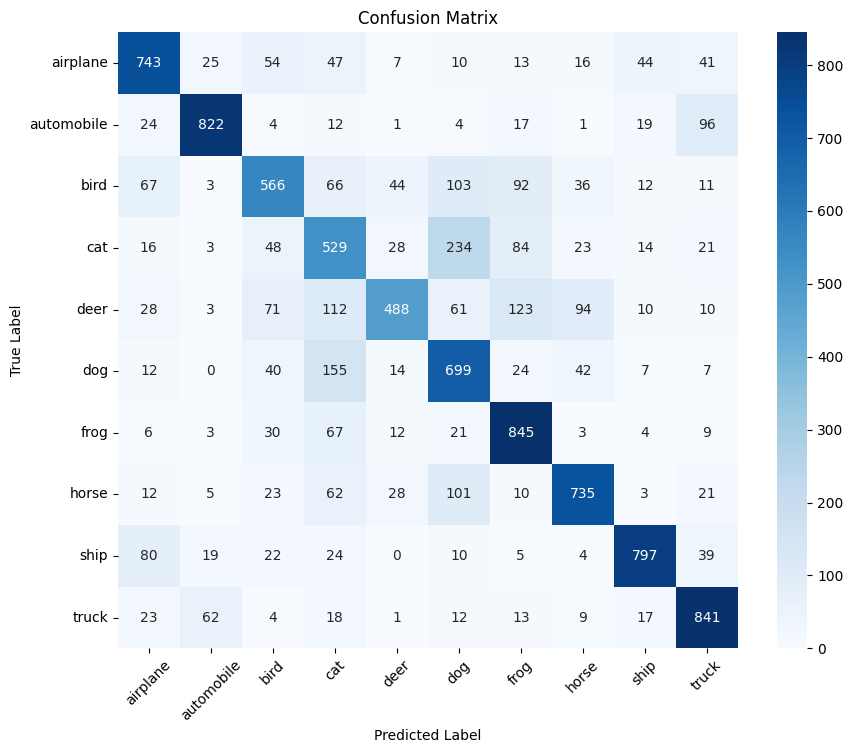

In [14]:
plot_confusion_matrix(y_test, y_pred, labels)

In [15]:
# ========== STEP 6: Save Model & Finish ==========
models_dir = "models/"

if not os.path.isdir(models_dir):
    os.mkdir(models_dir)


model.save("models/best_model.keras")
wandb.log_artifact("models/best_model.keras", type="model")
wandb.finish()

epoch/accuracy,▁▄▅▅▆▆▆▇▇▇▇▇▇█████
epoch/epoch,▁▁▂▂▃▃▃▄▄▅▅▆▆▆▇▇██
epoch/learning_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch/loss,█▅▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
epoch/val_accuracy,▁▄▄▆▆▇▇▇▇█▇██▆█▇▇▅
epoch/val_loss,█▄▇▂▂▂▂▂▂▁▁▁▁▃▁▂▃▇
final_val_accuracy,▁
final_val_loss,▁
epoch/accuracy,0.81745
epoch/epoch,17
epoch/learning_rate,0.001
